In [1]:
!pip install tensorflow==2.5.0 gym keras-rl2 gym[atari]

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files\python37\python.exe -m pip install --upgrade pip' command.


## I choose SpaceInvaders ROM for this assignment,which is an Atari-like game,and supported by OpenAI Gym.
## Space Invaders is a two-dimensional fixed shooter game in which the player controls a laser cannon by moving it horizontally across the bottom of the screen and firing at descending aliens. The aim is to defeat five rows of eleven aliens—some versions feature different numbers—that move horizontally back and forth across the screen as they advance towards the bottom of the screen. The player defeats an alien, and earns points, by shooting it with the laser cannon. As more aliens are defeated, the aliens' movement and the game's music both speed up. Defeating the aliens brings another wave that is more difficult, a loop which can continue without end.
## The aliens attempt to destroy the cannon by firing at it while they approach the bottom of the screen. If they reach the bottom, the alien invasion is successful and the game ends. A special 'mystery ship' will occasionally move across the top of the screen and award bonus points if destroyed. The laser cannon is partially protected by several stationary defense bunkers—the number varies by version—that are gradually destroyed by projectiles from the aliens and player.
## For the environment,I used tensorflow,pytorch,torchvision,numpy ,python3.6,gym==0.17.0.If use python3.7,the pytorch may conflict to numpy and throw error.
## Downloaded the game from this link:http://www.atarimania.com/rom_collection_archive_atari_2600_roms.html

# Import Libraries

In [2]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# Set Display

In [3]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

# Deep Q-Network

In [4]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=6)
        
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

# Experience class

In [5]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

# Replay Memory

In [6]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
    
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

# Epsilon Greedy Strategy

In [7]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

# Reinforcement Learning Agent

In [8]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    
    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            action = random.randrange(self.num_actions) #explore
            return torch.tensor([action]).to(device)
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(device) #exploit

# SpaceInvaders Environment Manager

In [9]:
class SpaceInvadersEnvManager():
    def __init__(self, device):
        self.device = device
#         Only SpaceInvaders-v0 and SpaceInvaders-v4 are available.
        self.env = gym.make('SpaceInvaders-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
        
    def reset(self):
        self.env.reset()
        self.current_screen = None
    
    def close(self):
        self.env.close()
    
    def render(self, mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
    
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1))
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transform_screen_data(self, screen):
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            , T.Resize((40,90))
            , T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device)

# Outputs of Experience

In [10]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(values)
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
          moving_avg_period, "episode score avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)
        
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension = 0, size = period, step = 1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

# Tensor Processing

In [11]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))
    
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    
    return (t1, t2, t3, t4)

# Q-Value Calculator

In [12]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

# Instructions

1.Establish a baseline performance. How well did your Deep Q-learning do on your problem? (5 Points)

batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 200
With this baseline performance, our RL program with the SpaceInvaders-v0 gives us a score of 162.15,and the score from the beginning is almost as high as the score at the end,means it learned nothing.

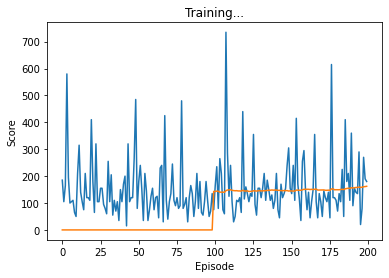

Episode 200 
 100 episode score avg: 162.15


In [13]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            plot(episode_scores, 100)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

2.What are the states, the actions, and the size of the Q-table? (5 Points)



States:RPG images shown on screen, which is an array of shape (210, 160, 3).
Actions:['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
Q-table=The number of states * The number of actions. Each state has different choices, the number of choices is the number of actions.

In [16]:
temp = gym.make('SpaceInvaders-v0')
print(temp.env.get_action_meanings())
print(temp.env.observation_space.shape)

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
(210, 160, 3)


3.What are the rewards? Why did you choose them? (5 Points)

Rewards:score of the game
Why:the goal of the game is to get a higher score,and score are easy to compare.

4.How did you choose alpha and gamma in the Bellman equation? Try at least one additional value for alpha and gamma. How did it change the baseline performance? (5 Points)

The values of alpha,shown as lr(learning rate) near to 1 make the changes in Q more fast. Alpha determines the extent to which newly acquired information covers old information. A factor of 0 means the agent learn nothing, and 1 means the agent consider only the most recent information.
The score for lr==0.001 is 162.15,and score for lr==0.9 is 125.85,so the smaller alpha is better.
Smaller the alpha is, more use of previous information can get a better game score.

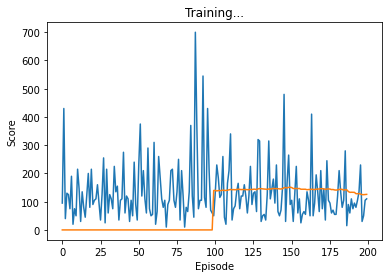

Episode 200 
 100 episode score avg: 125.85


In [17]:
# change lr from 0.001 to 0.9
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.9
num_episodes = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            plot(episode_scores, 100)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

In [ ]:
The score for gamma==0.999 is 162.15,and score for gamma==0.1 is ,so for episode 200,the smaller gamma is a little better.More use of current rewards can lead to higher scores faster.

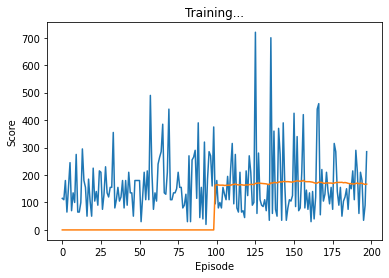

Episode 198 
 100 episode score avg: 166.9


In [ ]:
# change gamma from 0.999 to 0.1
batch_size = 256
gamma = 0.1
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            plot(episode_scores, 100)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

5.Try a policy other than e-greedy. How did it change the baseline performance? (5 Points)

Policy:Random Sampling

In [ ]:
When the number of actions get larger, the probability that the best behavior can be randomized get smaller. 
The score for RandomSampling is ,which is worse.

In [ ]:
class RandomSamplingStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

In [ ]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    
    def select_action(self, state, policy_net):
        self.current_step += 1

        action = random.randrange(self.num_actions) #explore
        return torch.tensor([action]).to(device)

In [ ]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = RandomSamplingStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            plot(episode_scores, 100)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

6.How did you choose your decay rate and starting epsilon? Try at least one additional value for epsilon and the decay rate. How did it change the baseline performance? What is the value of epsilon when if you reach the max steps per episode? (5 Points)

In [ ]:
Using the epsilon greedy strategy, we can define an exploration rate which means the probability that agent explores the environment instead and set it as 1.
When the decay rate is 0.6, the score is,which is .
When starting epsilon is 0.5, the score is,which is.
When decay rate is 0.001 and starting epsilon is 1, I reach the max steps per episode.

In [ ]:
# change eps_start from 1 to 0.6
batch_size = 256
gamma = 0.999
eps_start = 0.6
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            plot(episode_scores, 100)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

In [ ]:
# change eps_decay from 0.001 to 0.6
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.6
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            plot(episode_scores, 100)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

7.What is the average number of steps taken per episode? (5 Points)

In [ ]:
def plot_steps(values, steps_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.plot(values)
    steps_avg = get_steps_average(steps_avg_period, values)
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
          steps_avg_period, "episode steps avg:", steps_avg[-1])
    if is_ipython: display.clear_output(wait=True)
        
def get_steps_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        steps_avg = values.unfold(dimension = 0, size = period, step = 1) \
            .mean(dim=1).flatten(start_dim=0)
        steps_avg = torch.cat((torch.zeros(period-1), steps_avg))
        return steps_avg.numpy()
    else:
        steps_avg = torch.zeros(len(values))
        return steps_avg.numpy()

In [ ]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
steps = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    steps.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            steps[episode] = timestep
            plot_steps(steps, 100)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

8.Does Q-learning use value-based or policy-based iteration? (5 Points)
Explain, not a yes or no question.

Yes.Q learning is a value-based off-policy temporal difference (TD) reinforcement learning.
Explain:In the value-based method, a random value function is selected at first, and then a new value function is found. This process is repeated until the optimal value function is found. The strategy is to follow the optimal value function will be the optimal strategy. In Q-learning, we update the Q value to find the best strategy.

9.Could you use SARSA for this problem? (5 Points)
Explain, not a yes or no question.

Yes.Explain:The strategy used by the Q value is used to select actions from the state. After executing the action, observe the new state and use the strategy to select a new action in the new state, which is e-greedy now.

10.What is meant by the expected lifetime value in the Bellman equation? (5 Points)
Explain, not a yes or no question.

V(s)=maxa(R(s,a)+ γV(s’))
Value(V): Numeric representation of a state which helps the agent to find its path. V(s) here means the value of the states.
Bellman equation is a system of functional equations about unknown functions. The method of applying the optimization principle and embedding principle to establish a system of functional equations is called the functional equation method. Special solutions should be sought according to specific problems.

11.When would SARSA likely do better than Q-learning? (5 Points)
Explain, not a yes or no question.



SARSA will approach convergence allowing for possible penalties from exploratory moves, whilst Q-learning will ignore them. That makes SARSA more conservative - if there is risk of a large negative reward close to the optimal path, Q-learning will tend to trigger that reward whilst exploring, whilst SARSA will tend to avoid a dangerous optimal path and only slowly learn to use it when the exploration parameters are reduced. 

In practice, if the error is costly, use SARSA is a better choice. And if we care about the rewards we get in the learning process, then SARSA may be a better choice.

12.How does SARSA differ from Q-learning? (5 Points)
Details including pseudocode and math.



The most important difference between the two is how Q is updated after each operation.

SARSA uses Q' strictly in accordance with the ε-greedy policy, because A'is extracted from Q'. 

In the SARSA algorithm, given a policy, the corresponding action-value function Q (in the state s and action a, at timestep t), i.e. Q(st, at), can be updated as follows

Q(st, at) = Q(st, at) + α*(rt + γ*Q(st+1, at+1) - Q(st, at))

The pseudocode of SARSA is:
    
Initialize Q(s,a),∀s∈S,a∈A(s),arbitrarily,and Q(terminal-state,)=0
    
Repeat (for each episode):

    Initialize S

    Repeat (for each step of episode):

        Choose A from S using policy derived from Q

        Take action A, observe R,S'

        Q(S,A) ← Q(S,A) + α[R + γmaxαQ(S',a) - Q(S,A)]

        S ← S'

    until S is terminal
.

The update step for the Q-learning algorithm is the following

Q(st, at) = Q(st, at) + α*(rt + γ*maxa Q(st+1, a) - Q(st, at))

Which can also be written as

Q(st, at) = (1 - α) * Q(st, at) + α * (rt + γ*maxa Q(st+1, a))

Where γ (gamma) is the discount factor and rt is the reward received from the environment at timestep t.
                                       
The pseudocode of Q-learning is:
                                       
Initialize Q(s,a),∀s∈S,a∈A(s),arbitrarily,and Q(terminal-state,)=0

Repeat (for each episode):
    
    Initialize S
    
    Choose A from S using policy derived from Q
    
    Repeat (for each step of episode):
        
        Take action A, observe R,S'
        
        Choose A' from S' using policy derived from Q
        
        Q(S,A) ← Q(S,A) + α[R + γmaxαQ(S',a) - Q(S,A)]
                                       
        S ← S'
                                
    until S is terminal

So SARSA only looks up the next policy value while Q-learning looks up the next maximum policy value.



13.Explain the Q-learning algorithm. (5 Points)
Details including pseudocode and math.



Q-learning is a model-free reinforcement learning algorithm to learn the value of an action in a particular state. It does not require a model of the environment (hence "model-free"), and it can handle problems with stochastic transitions and rewards without requiring adaptations.

There are two hyperparameters need to be set: learning rate alpha and discount rate gamma. Alpha represents for how quickly agents will adopt new Q-value, and gamma determines whether agents are going to access immediate reward or future reward.

As the loss is reduced to zero, Q-value will no longer change, so the Q-value converges to the optimal Q-value.

The pseudocode as following:
    
Initialize Q(s,a),∀s∈S,a∈A(s),arbitrarily,and Q(terminal-state,)=0

Repeat (for each episode):
    
    Initialize S
    
    Repeat (for each step of episode):
        
        Choose A from S using policy derived from Q
        
        Take action A, observe R,S'
        
        Q(S,A) ← Q(S,A) + α[R + γmaxαQ(S',a) - Q(S,A)]
                                       
        S ← S'
                                
    until S is terminal
    

14.Explain the SARSA algorithm. (5 Points)
Details including pseudocode and math.

SARSA(State action reward state action) is an algorithm for learning a Markov decision process policy.SARSA is using TD method for evaluation and prediction.

The SARSA agent interacts with the environment and updates the policy based on the actions taken, so this is called a policy-based learning algorithm. The Q value of the state action is updated by the error and adjusted by the learning rate alpha. The Q value represents the possible reward for taking action a in state s in the next time step, plus the discounted future reward received from the next state-action observation.

The pseudocode as follow:
    
Initialize Q(s,a),∀s∈S,a∈A(s),arbitrarily,and Q(terminal-state,)=0

Repeat (for each episode):
    
    Initialize S
    
    Choose A from S using policy derived from Q
    
    Repeat (for each step of episode):
        
        Take action A, observe R,S'
        
        Choose A' from S' using policy derived from Q
        
        Q(S,A) ← Q(S,A) + α[R + γmaxαQ(S',a) - Q(S,A)]
                                       
        S ← S'
                                
    until S is terminal

15.What code is yours and what have you adapted? (5 Points)
You must explain what code you wrote and what you have done that is different. Failure to cite ANY code will result in a zero for this section.

I wrote and adapted the Instructions part, make it more efficient and fit

https://towardsdatascience.com/q-learning-algorithm-from-explanation-to-implementation-cdbeda2ea187
https://www.researchgate.net/figure/Pseudocode-for-the-implemented-Q-learning-algorithm_fig4_344634163
https://blog.csdn.net/zzl_sjtu/article/details/124268375?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522166723041316782417047757%2522%252C%2522scm%2522%253A%252220140713.130102334.pc%255Fall.%2522%257D&request_id=166723041316782417047757&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~first_rank_ecpm_v1~rank_v31_ecpm-1-124268375-null-null.142^v62^pc_search_tree,201^v3^control_2,213^v1^control&utm_term=ale_py%20roms&spm=1018.2226.3001.4187
https://stackoverflow.com/questions/6848828/what-is-the-difference-between-q-learning-and-sarsa

17.Did I explain my licensing clearly? (5 Points)
Failure to cite a clear license will result in a zero for this section.

Copyright 2022 Yiyun Chen

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.